In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import json

%matplotlib inline

#!pip install nltk sklearn wordcloud pymorphy2 stop_words

### Preprocessing

In [75]:
import nltk
from nltk.stem import SnowballStemmer
import stop_words

In [37]:
with open('data.json', 'r', encoding='utf-8') as f:
    raw_data = json.load(f) 
# print(raw_data)

In [38]:
classes = ['Sport', 'Music', 'Travel', 'Science']

In [39]:
raw_corpus = []
target = []
for item in raw_data['catalog']:
    raw_corpus.append(item['text'])
    target.append(classes.index(item['category']))
# raw_corpus[0]

In [40]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

In [41]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)

In [42]:
stop_list = stop_words.get_stop_words('en')
# stop_list

In [43]:
snowball = SnowballStemmer(language="english")

Удаляем знаки препинания, стоп-слова и приводим слова к единой форме для каждого текста в корпусе:

In [44]:
def one_text_preproc(doc):
    filtered_doc = regex_punct.sub('', doc)
    filtered_doc = regex_symb.sub('', filtered_doc)
    # filtered_doc

    words_dict = []
    splited_doc = filtered_doc.split(' ')
    for word in splited_doc:
        word = word.lower()
        if word not in stop_list:
            words_dict.append(word)
    # words_dict

    tokens_dict = []
    for word in words_dict:
        tokens_dict.append(snowball.stem(word))
    # tokens_dict

    new_doc = ''
    for i in tokens_dict:
        new_doc += f'{i} '

    return new_doc[:-1]

In [45]:
corpus = []
for doc in raw_corpus:
    corpus.append(one_text_preproc(doc))
# corpus

### Vectorization

In [76]:
from sklearn.feature_extraction.text import CountVectorizer

In [46]:
vectorizer = CountVectorizer()

In [47]:
data = vectorizer.fit_transform(corpus)
data = data.toarray().tolist()

### Models

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm 
from sklearn.neural_network import MLPClassifier 

In [50]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.25, random_state=2)

In [51]:
LR = LogisticRegression(solver='lbfgs', multi_class='multinomial')
LR.fit(data_train, target_train)
pred_lr = LR.predict(data_test)
print(f'Accuracy:  {accuracy_score(target_test, pred_lr)}')

Accuracy:  0.976


In [52]:
RF = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
RF.fit(data_train, target_train)
pred_rf = RF.predict(data_test)
print(f'Accuracy:  {accuracy_score(target_test, pred_rf)}')

Accuracy:  0.956


In [53]:
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1)
NN.fit(data_train, target_train) 
pred_nn = NN.predict(data_test) 
print(f'Accuracy:  {accuracy_score(target_test, pred_nn)}')

Accuracy:  0.97


In [54]:
NB = MultinomialNB()
NB.fit(data_train, target_train)
pred_nb = NB.predict(data_test)
print(f'Accuracy:  {accuracy_score(target_test, pred_nb)}')

Accuracy:  0.967


In [55]:
SGD = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
SGD.fit(data_train, target_train)
pred_sgd = SGD.predict(data_test)
print(f'Accuracy:  {accuracy_score(target_test, pred_sgd)}')

Accuracy:  0.982


In [56]:
SVM = svm.SVC(decision_function_shape="ovo")
SVM.fit(data_train, target_train) 
pred_svm = SVM.predict(data_test) 
print(f'Accuracy:  {accuracy_score(target_test, pred_svm)}')

Accuracy:  0.969


Все модели показали практически одинаковую точность - 97%. Наилучший результат - 98% у SGD классификатора

В качестве метрици оценки точности использовалась сама я простая - accuracy

Поэтому для большего понимания рассмотрим матрицы ошибок для каждой из моделей.

In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

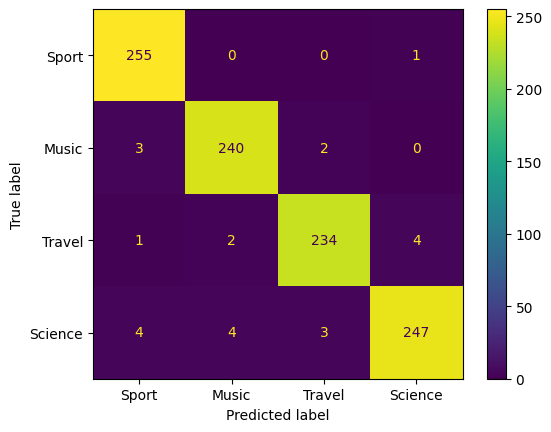

In [61]:
ConfusionMatrixDisplay(confusion_matrix(target_test, pred_lr), display_labels=classes).plot()

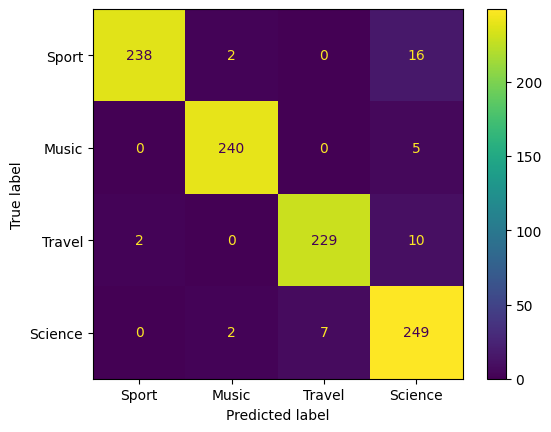

In [62]:
ConfusionMatrixDisplay(confusion_matrix(target_test, pred_rf), display_labels=classes).plot()

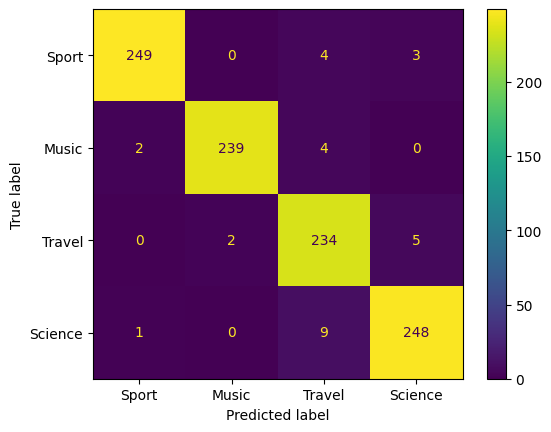

In [63]:
ConfusionMatrixDisplay(confusion_matrix(target_test, pred_nn), display_labels=classes).plot()

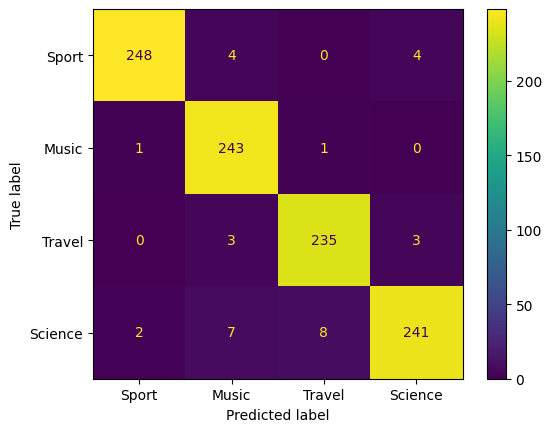

In [64]:
ConfusionMatrixDisplay(confusion_matrix(target_test, pred_nb), display_labels=classes).plot()

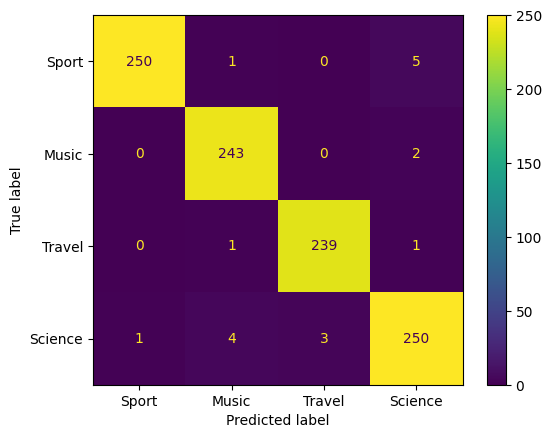

In [65]:
ConfusionMatrixDisplay(confusion_matrix(target_test, pred_sgd), display_labels=classes).plot()

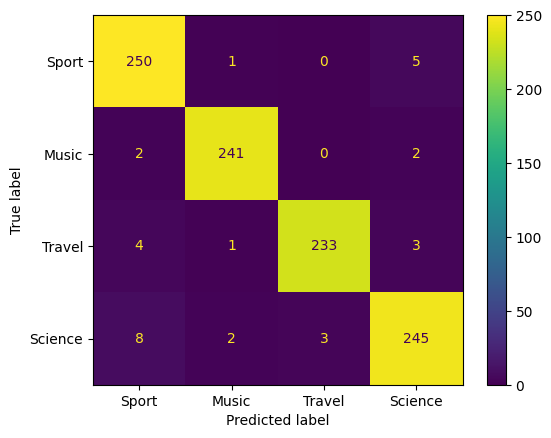

In [66]:
ConfusionMatrixDisplay(confusion_matrix(target_test, pred_svm), display_labels=classes).plot()

Видно, что модели практически не делали ложных предсказаний.

Больше всего ошибок допустила модель RandomForest и слишком часто распознавала как "науку" тексты из других категорий.

(В планах еще были feature importance, но оказалось, что features слишком много)

Предположительно высокая точность классификации обусловлена тем, что области новостей практически никак не пересекаются и достаточно просто различимы по ключевым словам.